# OBJECTIF : 

On récupère les données du fichier dynamique cecido, on regarde ce qu'on obtient de ces données. Les résultats obtenus sont commentés dans le fichier RESULTATS EXTRAITS DU FICHIER DYNAMIQUE.docx

## Importation des librairies

In [1]:
library (plyr)
library (dplyr)
library (readr)
library (xlsxjars)
library (xlsx)
library (float)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: rJava


In [3]:
getwd()

[1] "/home/laurie/Dropbox/Cecidomyie/R"

## On se place dans le fichier dynamique cecido

In [4]:
#setwd("../Fichiers de donnees/Donnees brutes")

# Lecture du fichier dynamique cecido
data1 = read.xlsx2("../Fichiers de donnees/Donnees brutes/dynamique.cecido.modif0.xlsx", 1)

# On change les dates en "DD/MM/YYYY"
unique_date = as.character(unique(data1$date))
date = c('01/09/2017','06/09/2017','08/09/2017','13/09/2017','15/09/2017','20/09/2017','22/09/2017','26/09/2017','29/09/2017',
         '03/10/2017','06/10/2017')
data1$date = as.character(as.numeric(as.character(data1$date)))
for (i in 1:length(date))
    data1$date[data1$date==unique_date[i]] = date[i] 

## Durée des stades phénologiques (thèse de Paul)

In [10]:
# Durée cumulée entre chaque stade (estimations faites à partir des données de notre fichier dynamique.cecido)
stade = c('C','D1','D2','E','F','G')
debut_stade = cumsum(c(0,1,4,4,7,28,7))
fin_stade = rev(cumsum(rev(c(1,4,4,7,28,7,0))))

## Duree de vie des inflorescences

In [6]:
# On enlève les stades phénos non observés et les stades végétatifs
data1_0 = data1[data1$stade!='NA' & data1$stade!='V',]

# On sépare selon le bloc, le traitement du sol, l'arbre, le piège, et le numéro d'étiquette afin d'avoir toutes les 
# étiquettes suivies séparées 
data1_split = split(data1_0, list(data1_0$bloc,data1_0$trait,data1_0$arbre,data1_0$piege,data1_0$num.etiq))

# Nombre d'étiquettes suivies avec des stades phénos observés
NbGroup = length(data1_split)

# Initisalisation
cecido = c()
birth = structure(rep(NA_real_, 130), class="Date")
dead  = structure(rep(NA_real_, 130), class="Date")

jj = 1

# Pour chaque étiquette :
    # On récupère la date de naissance de l'inflo (premier stade phéno observé si c'est le stade C,
    # sinon estimation de la date d'apparition du stade C avec duree_stade et debut_stade).
    # On récupère la date de mort de l'inflo (premier 5 dans le niveau de déssechement, signifie qu'elle est sèche à 100%).
    # Si elle n'atteint pas l'état de déssèchement 5, on estime sa date de mort avec les durées des stades.
for (i in 1:NbGroup) {
    tmp = data.frame(data1_split[i])
    colnames(tmp) = colnames(data1_0)
    tmp$date = as.Date(tmp$date, '%d/%m/%Y')
    tmp$date = as.Date(strptime(tmp$date, format = "%Y-%m-%d"))
    tmp$stade = as.character(tmp$stade)
    if (dim(tmp)[1]!=0) {
        premier_stade = tmp$stade[1]
        ii = which(stade == premier_stade)
        birth[jj] = tmp$date[1] - debut_stade[ii]
        if (1 %in% tmp$cecido) 
            cecido = c(cecido,1)
        else
            cecido = c(cecido,0)
        if (5 %in% tmp$etat.panicule) {
            j = min(which(tmp$etat.panicule == 5))
            dead[jj] = tmp$date[j]
        }
        else {
            dernier_stade = tmp$stade[dim(tmp)[1]]
            ii = which(stade == dernier_stade)
            dead[jj] = tmp$date[dim(tmp)[1]] + fin_stade[ii]
        }
        jj = jj+1
    }
}
diff = dead-birth

In [8]:
# On crée un fichier contenant newdata1
newdata1 = data.frame(birth, dead, diff)
write.xlsx(newdata1, "..//Fichiers de donnees/Donnees re organisees/Fichier dynamique cecido/dynamique_cecido_data.xls", sheetName="1")

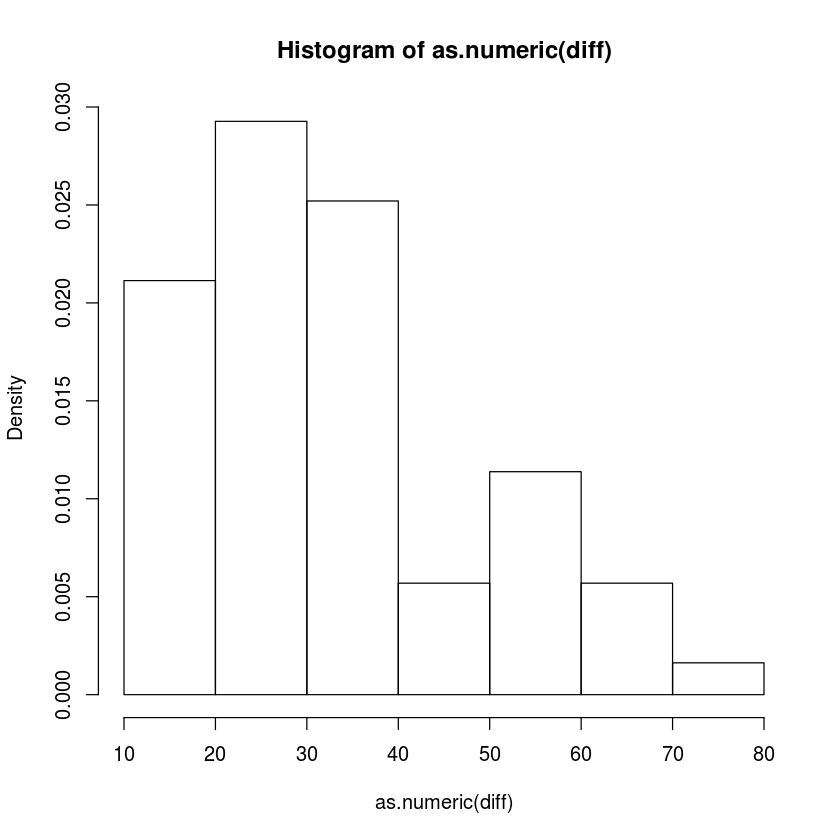

In [9]:
# Histogramme des durées de vie des inflorescences (On a récupéré toutes les durées de vie des inflos que nous avons et 
# on les a mises dans un histogramme)
hist(as.numeric(diff),freq=F)
# Densité de proba d'une loi normale de moyenne, la durée de vie moyenne des inflos et de variance, la variance des inflos
curve(dnorm(x,mean(diff),sd(diff)),from=-10,to=70,add=T,col="red")

## A quel stade phénologique, l'inflo meurt-elle? 

In [11]:
# On enlève les stades phénos non observés et les stades végétatifs
data1_0 = data1[data1$stade!='NA' & data1$stade!='V' & data1$cecido=='1',]

# On sépare selon le bloc, le traitement du sol, l'arbre, le piège, et le numéro d'étiquette afin d'avoir toutes les 
# étiquettes suivies séparées 
data1_split = split(data1_0, list(data1_0$bloc,data1_0$trait,data1_0$arbre,data1_0$piege,data1_0$num.etiq))

# Nombre d'étiquettes suivies avec des stades phénos observés
NbGroup = length(data1_split)

# Initialisation 
stade_fin = c()

jj = 1

# Pour chaque étiquette :
    # Si l'inflo atteint l'état de déssèchement 5, on garde le stade phénologique durant lequel elle est morte
for (i in 1:NbGroup) {
    tmp = data.frame(data1_split[i])
    colnames(tmp) = colnames(data1_0)
    tmp$date = as.Date(tmp$date, '%d/%m/%Y')
    tmp$date = as.Date(strptime(tmp$date, format = "%Y-%m-%d"))
    tmp$stade = as.character(tmp$stade)
    if (dim(tmp)[1]!=0) {
        if (5 %in% tmp$etat.panicule) {
            j = min(which(tmp$etat.panicule == 5))
            stade_fin = c(stade_fin, tmp$stade[j])
            
        }
    }
}

print("Proportion d'inflos qui meurent à l'état phénologique C : ")
print(sum(stade_fin=='C')/length(stade_fin))
print("")
print("Proportion d'inflos qui meurent à l'état phénologique D1 : ")
print(sum(stade_fin=='D1')/length(stade_fin))
print("")
print("Proportion d'inflos qui meurent à l'état phénologique D2 : ")
print(sum(stade_fin=='D2')/length(stade_fin))
print("")
print("Proportion d'inflos qui meurent à l'état phénologique E : ")
print(sum(stade_fin=='E')/length(stade_fin))
print("")
print("Proportion d'inflos qui meurent à l'état phénologique F : ")
print(sum(stade_fin=='F')/length(stade_fin))
print("")
print("Proportion d'inflos qui meurent à l'état phénologique G : ")
print(sum(stade_fin=='G')/length(stade_fin))

[1] "Proportion d'inflos qui meurent à l'état phénologique C : "
[1] 0
[1] ""
[1] "Proportion d'inflos qui meurent à l'état phénologique D1 : "
[1] 0
[1] ""
[1] "Proportion d'inflos qui meurent à l'état phénologique D2 : "
[1] 0.04
[1] ""
[1] "Proportion d'inflos qui meurent à l'état phénologique E : "
[1] 0.1466667
[1] ""
[1] "Proportion d'inflos qui meurent à l'état phénologique F : "
[1] 0.72
[1] ""
[1] "Proportion d'inflos qui meurent à l'état phénologique G : "
[1] 0.09333333


## Stade atteint 

In [12]:
# On enlève les stades phénos non observés et les stades végétatifs
data1_0 = data1[data1$stade!='NA' & data1$stade!='Fruit',]

# On sépare selon le bloc, le traitement du sol, l'arbre, le piège, et le numéro d'étiquette afin d'avoir toutes
# les étiquettes suivies séparées 
data1_split = split(data1_0, list(data1_0$bloc,data1_0$trait,data1_0$arbre,data1_0$piege,data1_0$num.etiq))

# Nombre d'étiquettes suivies avec des stades phénos observés
NbGroup = length(data1_split)

# Initialisation
stade_atteint_mort=matrix(rep(0,24),4,6)
colnames(stade_atteint_mort) = c('C','D1','D2','E','F','G')
rownames(stade_atteint_mort) = c("Atteint","Mort","Sain_p","Mort_p")

# Pour chaque étiquette :
    # On cherche le stade phénologique maximal que l'inflo atteint, on connait donc tous les stades par lesquels 
    # elle est passée. Et on regarde si elle meurt pendant ce stade.
for (i in 1:NbGroup) {
    tmp = data.frame(data1_split[i])
    colnames(tmp) = colnames(data1_0)
    tmp$date = as.Date(tmp$date, '%d/%m/%Y')
    tmp$date = as.Date(strptime(tmp$date, format = "%Y-%m-%d"))
    tmp$stade = as.character(tmp$stade)
    if (sum(tmp$stade=='V')==0 & dim(tmp)[1]!=0) {
        dd = unique(tmp$stade)
        stade_max = dd[length(dd)]
        stade_max_i = which(stade_max==stade)
        stade_atteint_mort[1,1:stade_max_i] = stade_atteint_mort[1,1:stade_max_i] + 1
        if (stade_max!='G')
            stade_atteint_mort[2,stade_max] = stade_atteint_mort[2,stade_max] + 1
        else {
            if ('5' %in% tmp$etat.panicule)
                stade_atteint_mort[2,stade_max] = stade_atteint_mort[2,stade_max] + 1
        }
    }
}

stade_atteint_mort[3,] = stade_atteint_mort[2,]/stade_atteint_mort[1,] * 100
stade_atteint_mort[4,] = (1 - stade_atteint_mort[2,]/stade_atteint_mort[1,]) * 100 

stade_atteint_mort

,C,D1,D2,E,F,G
Atteint,128,128,128.000,124.00000,103.00000,27.00000
Mort,0,0,4.000,21.00000,76.00000,7.00000
Sain_p,0,0,3.125,16.93548,73.78641,25.92593
Mort_p,100,100,96.875,83.06452,26.21359,74.07407


## Nombre de piqûres moyen lorsque l'inflo meurt en fonction du stade phénologique atteint

In [13]:
# On enlève les stades phénos non observés et les stades végétatifs
data1_0 = data1[data1$stade!='NA',]

# On sépare selon le bloc, le traitement du sol, l'arbre, le piège, et le numéro d'étiquette afin d'avoir toutes les 
# étiquettes suivies séparées 
data1_split = split(data1_0, list(data1_0$bloc,data1_0$trait,data1_0$arbre,data1_0$piege,data1_0$num.etiq))

# Nombre d'étiquettes suivies avec des stades phénos observés
NbGroup = length(data1_split)

# Initialisation
larves_D2 = c()
larves_E  = c()
larves_F  = c()
larves_G  = c()

# Pour chaque étiquette : 
    # On cherche le stade phénologique où l'inflorescence meurt et le nombre de piqûres au moment où elle meurt
for (i in 1:NbGroup) {
    tmp = data.frame(data1_split[i])
    colnames(tmp) = colnames(data1_0)
    tmp$stade = as.character(tmp$stade)
    N = dim(tmp)[1]
    if (sum(tmp$stade=='V')==0 & sum(tmp$stade=='Fruit')==0 & dim(tmp)[1]!=0) {
        dd = unique(tmp$stade)
        stade_max = dd[length(dd)]
        stade_max_i = which(stade_max==stade)
        if (stade_max!='G') {
            piqures = tmp$nb.piqures[tmp$nb.piqures!='NA']
            piqures = as.numeric(as.character(piqures))
            piqure = max(piqures)
            if (stade_max_i==3) 
                larves_D2 = c(larves_D2, piqure)
            if (stade_max_i==4)
                larves_E  = c(larves_E, piqure)
            if (stade_max_i==5) 
                larves_F  = c(larves_F, piqure)
        }
        else {
            if ('5' %in% tmp$etat.panicule) {          
                piqures = tmp$nb.piqures[tmp$nb.piqures!='NA']
                piqures = as.numeric(as.character(piqures))
                piqure = max(piqures)
                larves_G  = c(larves_G, piqure)
            }
        }
    }
}

[1] "D2"
[1] 4.75
[1] 2.362908
[1] 4
[1] ""
[1] "E"
[1] 3.619048
[1] 2.479439
[1] 21
[1] ""
[1] "F"
[1] 10.28
[1] 10.12831
[1] 75
[1] ""
[1] "G"
[1] 10.28571
[1] 9.068522
[1] 7


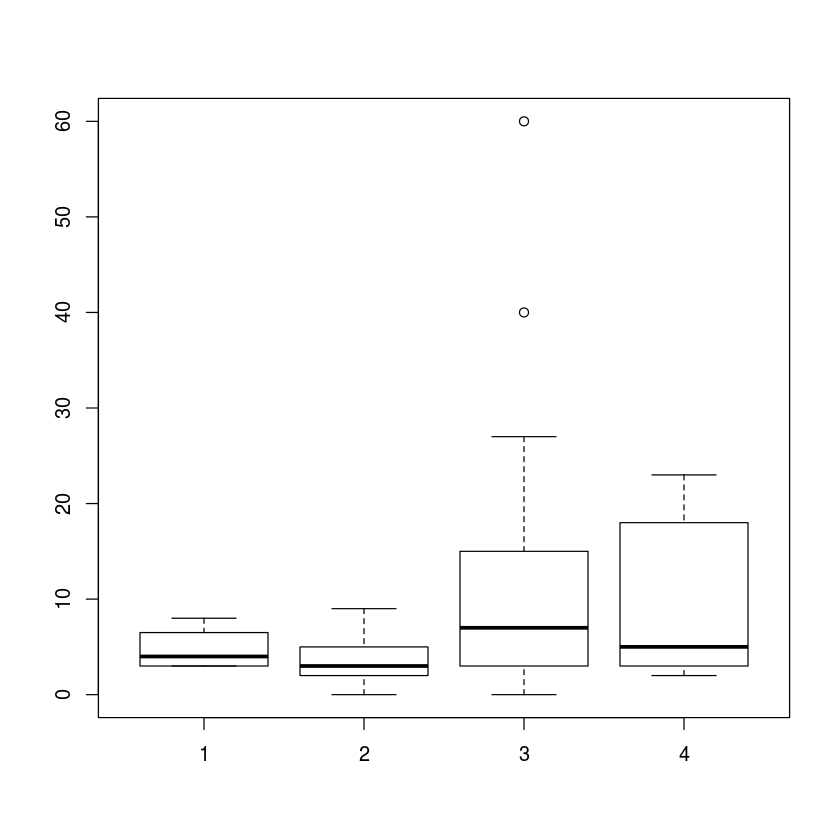

In [14]:
# Moyenne variance du nombre de piqûre par stade phénologique de mort
# Effectif du nombre d'inflorescence mortes par stade 
print ("D2")
print (mean(larves_D2))
print (sd(larves_D2))
print (length(larves_D2))
print ("")
print ("E")
print (mean(larves_E))
print (sd(larves_E))
print (length(larves_E))
print ("")
print ("F")
print (mean(larves_F))
print (sd(larves_F))
print (length(larves_F))
print ("")
print ("G")
print (mean(larves_G))
print (sd(larves_G))
print (length(larves_G))

boxplot(larves_D2, larves_E, larves_F, larves_G)

[1] "D2"
[1] 4.75
[1] 2.362908
[1] 4
[1] ""
[1] "E"
[1] 3.619048
[1] 2.479439
[1] 21
[1] ""
[1] "F"
[1] 9.191781
[1] 7.591401
[1] 73
[1] ""
[1] "G"
[1] 10.28571
[1] 9.068522
[1] 7


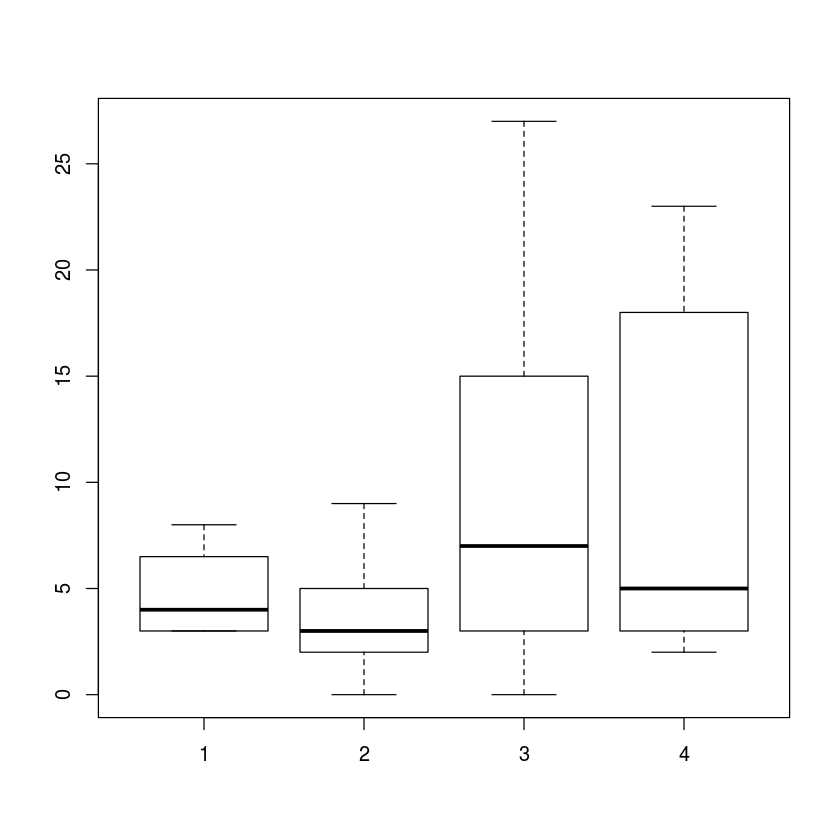

In [15]:
larves_F = larves_F[-which(larves_F==60)]
larves_F = larves_F[-which(larves_F==40)]

# Moyenne variance du nombre de piqûre par stade phénologique de mort
# Effectif du nombre d'inflorescence mortes par stade 
print ("D2")
print (mean(larves_D2))
print (sd(larves_D2))
print (length(larves_D2))
print ("")
print ("E")
print (mean(larves_E))
print (sd(larves_E))
print (length(larves_E))
print ("")
print ("F")
print (mean(larves_F))
print (sd(larves_F))
print (length(larves_F))
print ("")
print ("G")
print (mean(larves_G))
print (sd(larves_G))
print (length(larves_G))

boxplot(larves_D2, larves_E, larves_F, larves_G)

## Graphe du nombre d'inflorescences en fonction du temps. Couleurs pour le stade phénologique. 

In [16]:
# Lecture du fichier dynamique cecido
data1 = read.xlsx2("../Donnees brutes/dynamique.cecido.modif0.xlsx", 1)

ERROR: Error in loadWorkbook(file, password = password): Cannot find ../Donnees brutes/dynamique.cecido.modif0.xlsx


In [ ]:
# On change les dates en "DD/MM/YYYY"
unique_date = as.character(unique(data1$date))
date = c('01/09/2017','06/09/2017','08/09/2017','13/09/2017','15/09/2017','20/09/2017','22/09/2017','26/09/2017','29/09/2017',
         '03/10/2017','06/10/2017')
data1$date = as.character(as.numeric(as.character(data1$date)))
for (i in 1:length(date))
    data1$date[data1$date==unique_date[i]] = date[i] 

stade = c('C','D1','D2','E','F','G')
debut_stade = cumsum(c(0,1,4,4,6,12,11))
fin_stade = rev(cumsum(rev(c(1,4,4,6,12,11,0))))

date = c('2017-09-01','2017-09-06','2017-09-08','2017-09-13','2017-09-15','2017-09-20','2017-09-22','2017-09-26','2017-09-29',
         '2017-10-03','2017-10-06')

In [ ]:
# Cette fonction renvoie le nombre d'inflorescences en fonction du stades phnéologiques pour chaque date dse relevé
# Et fait un graphe 

stade_inflo = function(bloc_) {

    data1_0 = data1[data1$bloc==bloc_ & data1$stade!='NA',]
    data1_split = split(data1_0, list(data1_0$bloc,data1_0$trait,data1_0$arbre,data1_0$piege,data1_0$num.etiq))
    NbGroup = length(data1_split)
    STADES = array(,c(NbGroup,length(date)))
    colnames(STADES) = date
    jj = 1

    # Pour chaque étiquette :
    # On récupère les dates de chaque stade phénologique C, D1, D2, E, F et G 

    for (i in 1:NbGroup) {
        tmp = data.frame(data1_split[i])
        colnames(tmp) = colnames(data1_0)
        tmp$date = as.Date(tmp$date, '%d/%m/%Y')
        tmp$date = as.Date(strptime(tmp$date, format = "%Y-%m-%d"))
        tmp$stade = as.character(tmp$stade)
        if (dim(tmp)[1]!=0) {
            k = 1
            if (5 %in% tmp$etat.panicule)
                j = min(which(tmp$etat.panicule == 5))
            else
                j = dim(tmp)[1]
            while (k <= j) {
                date_stade = tmp$date[k]
                STADES[jj,as.character(date_stade)] = tmp$stade[k]
                k = k+1
            }
            jj = jj+1
        }
    }
    
    STADES = STADES[1:jj-1,]

    stade = c('C','D1','D2','E','F','G','V')
    STADES = as.data.frame(STADES)
    STADES_ = array(0,c(length(stade),length(date)))
    colnames(STADES_) = date
    rownames(STADES_) = stade
    for (i in 1:length(date)) {
        for (j in 1:length(stade))
            STADES_[j,i] = length(which(STADES[date[i]]==stade[j]))
    }

    m  = STADES_
    m  = t(apply(m,2,cumsum))
    n1 = dim(m)[1]
    n2 = dim(m)[2]
    plot.new()
    plot.window(xlim=c(1,n1), ylim=c(min(m),max(m)))
    axis(1, 1:n1, date[1:n1])
    axis(2)
    col = c("chartreuse1","yellow","coral","darkorange","red","cadetblue","darkolivegreen","darkgrey")
    for (i in n2:1)
        polygon(c(1:n1,n1,1), c(m[,i],0,0), col=col[i])
    legend("topright", legend=stade, fill=col)
    
    return (STADES_)

}

In [ ]:
# BLOC 1 

stade_Bloc1 = stade_inflo(1)
print (stade_Bloc1)

In [ ]:
# BLOC 2

stade_Bloc2 = stade_inflo(2)
print (stade_Bloc2)

## A partir de la date du stade F, on veut essayer de reconstruire les dates de tous les stades précédents et voir les cinétiques obtenues

In [ ]:
tmp = data1$date
tmp = as.Date(tmp, '%d/%m/%Y')
tmp = as.Date(strptime(tmp, format = "%Y-%m-%d"))
date = sort(unique(tmp))

data1_0 = data1[data1$etat.panicule!='5',]
data1_split = split(data1_0, list(data1_0$bloc,data1_0$trait,data1_0$arbre,data1_0$piege,data1_0$num.etiq))
NbGroup = length(data1_split)

nb = length(date)

m = matrix(0,3,nb)

stadeD = c('C', 'D1', 'D2')
stadeE = c('E')
stadeF = c('F','G')

for (i in 1:NbGroup) {
    tmp = data.frame(data1_split[i])
    colnames(tmp) = colnames(data1_0)
    tmp$date = as.Date(tmp$date, '%d/%m/%Y')
    tmp$date = as.Date(strptime(tmp$date, format = "%Y-%m-%d"))
    N = dim(tmp)[1]
    if (N!=0) {
        for (j in 1:N) {
            tmp_ = tmp[j,]
            k = which(tmp_$date==date)
            if (tmp_$stade %in% stadeD) 
                m[1,k] = m[1,k] + 1
            if (tmp_$stade %in% stadeE) 
                m[2,k] = m[2,k] + 1
            if (tmp_$stade %in% stadeF) 
                m[3,k] = m[3,k] + 1
        }
    }
}

m  = apply(m,2,cumsum)
n1 = dim(m)[1]
n2 = dim(m)[2]
plot.new()
plot.window(xlim=c(1,n2), ylim=c(min(m),max(m)))
axis(1, 1:n2, date[1:n2])
axis(2)
col = c("chartreuse1","yellow","coral","darkorange","red")
for (i in n1:1)
    polygon(c(1:n2,n2,1), c(m[i,],0,0), col=col[i])
legend("topright", legend=c('D','E','F'), fill=col)
title("OBSERVATIONS")

data1_0 = data1[data1$stade=='F',]
data1_split = split(data1_0, list(data1_0$bloc,data1_0$trait,data1_0$arbre,data1_0$piege,data1_0$num.etiq))
NbGroup = length(data1_split)

date_F = structure(rep(NA_real_, 0), class="Date")

for (i in 1:NbGroup) {
    tmp = data.frame(data1_split[i])
    colnames(tmp) = colnames(data1_0)
    tmp$date = as.Date(tmp$date, '%d/%m/%Y')
    tmp$date = as.Date(strptime(tmp$date, format = "%Y-%m-%d"))
    if (dim(tmp)[1]!=0)
        date_F = c(date_F, tmp[1,]$date)
}

#date_G = date_F + 28
date_E = date_F - 7
date_D = date_E - 7

date = sort(unique(c(date_D, date_E, date_F)))#, date_G)))

nb = length(date)

m = matrix(0,3,nb)

for (j in 1:nb) {
    D = length(which(date_D==date[j]))
    E = length(which(date_E==date[j]))
    F = length(which(date_F==date[j]))
    m[1,j:min(nb,(j+7))] = m[1,j:min(nb,(j+7))] + D
    m[2,j:min(nb,(j+7))] = m[2,j:min(nb,(j+7))] + E
    m[3,j:min(nb,(j+28))] = m[3,j:min(nb,(j+28))] + F     
}

a = which(date=='2017-09-01')
m = m[,5:dim(m)[2]]
m  = apply(m,2,cumsum)
n1 = dim(m)[1]
n2 = dim(m)[2]
plot.new()
plot.window(xlim=c(1,n2), ylim=c(min(m),max(m)))
axis(1, 1:(n2-a+1), date[a:n2])
axis(2)
col = c("chartreuse1","yellow","coral","darkorange","red")
for (i in n1:1)
    polygon(c(1:n2,n2,1), c(m[i,],0,0), col=col[i])
legend("topright", legend=c('D','E','F'), fill=col)
title("DUREES DE PAUL")

data1_0 = data1[data1$stade=='F',]
data1_split = split(data1_0, list(data1_0$bloc,data1_0$trait,data1_0$arbre,data1_0$piege,data1_0$num.etiq))
NbGroup = length(data1_split)

date_F = structure(rep(NA_real_, 0), class="Date")

for (i in 1:NbGroup) {
    tmp = data.frame(data1_split[i])
    colnames(tmp) = colnames(data1_0)
    tmp$date = as.Date(tmp$date, '%d/%m/%Y')
    tmp$date = as.Date(strptime(tmp$date, format = "%Y-%m-%d"))
    if (dim(tmp)[1]!=0)
        date_F = c(date_F, tmp[1,]$date)
}

#date_G = date_F + 48
date_E = date_F - 9
date_D = date_E - 7

date = sort(unique(c(date_D, date_E, date_F)))#, date_G)))

nb = length(date)

m = matrix(0,3,nb)

for (j in 1:nb) {
    D = length(which(date_D==date[j]))
    E = length(which(date_E==date[j]))
    F = length(which(date_F==date[j]))
    m[1,j:min(nb,(j+9))] = m[1,j:min(nb,(j+9))] + D
    m[2,j:min(nb,(j+7))] = m[2,j:min(nb,(j+7))] + E
    m[3,j:min(nb,(j+48))] = m[3,j:min(nb,(j+48))] + F
}

a = which(date=='2017-09-01')
m = m[,5:dim(m)[2]]
m  = apply(m,2,cumsum)
n1 = dim(m)[1]
n2 = dim(m)[2]
plot.new()
plot.window(xlim=c(1,n2), ylim=c(min(m),max(m)))
axis(1, 1:(n2-a+1), date[a:n2])
axis(2)
col = c("chartreuse1","yellow","coral","darkorange","red")
for (i in n1:1)
    polygon(c(1:n2,n2,1), c(m[i,],0,0), col=col[i])
legend("topright", legend=c('D','E','F'), fill=col)
title("DUREES D'ANNE SARAH")

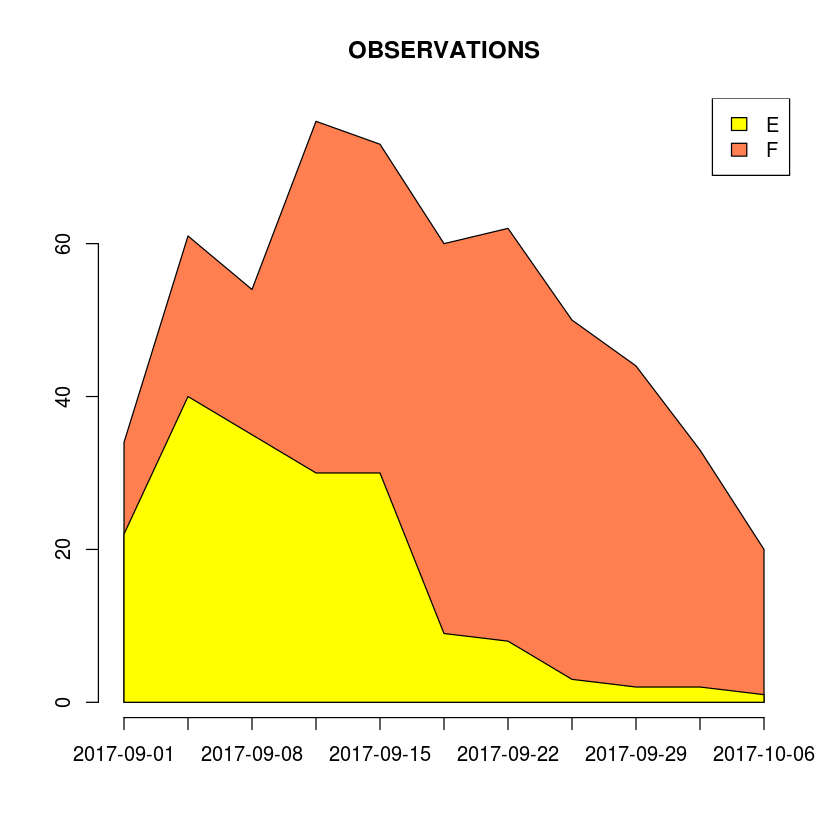

ERROR: Error in m[1, j:min(nb, (j + 7))]: subscript out of bounds


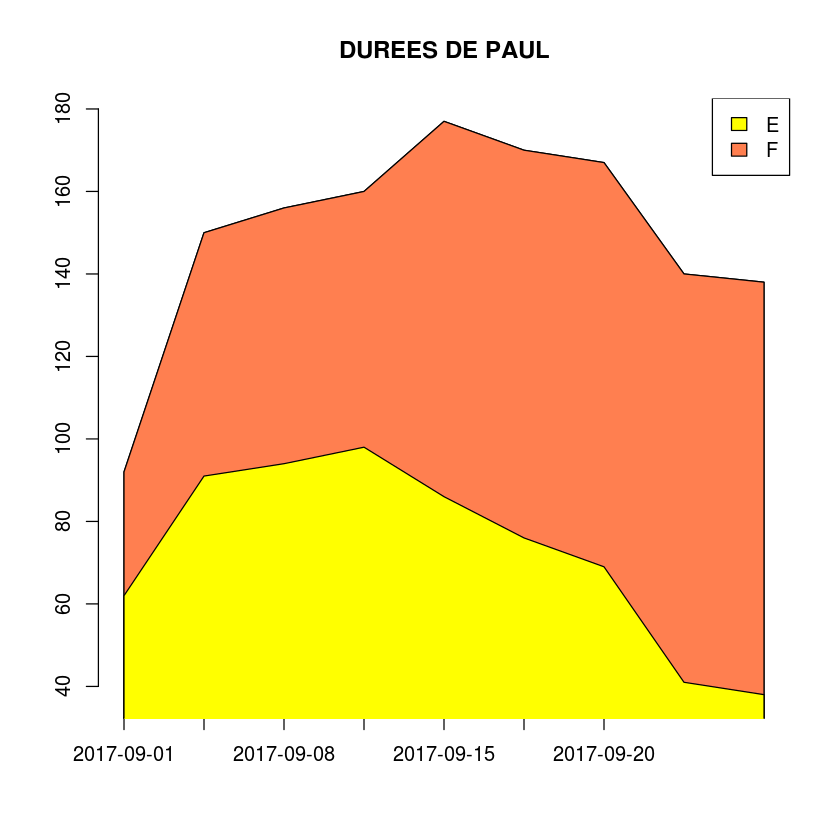

In [113]:
tmp = data1$date
tmp = as.Date(tmp, '%d/%m/%Y')
tmp = as.Date(strptime(tmp, format = "%Y-%m-%d"))
date = sort(unique(tmp))

data1_0 = data1[data1$etat.panicule!='5',]
data1_split = split(data1_0, list(data1_0$bloc,data1_0$trait,data1_0$arbre,data1_0$piege,data1_0$num.etiq))
NbGroup = length(data1_split)

nb = length(date)

m = matrix(0,2,nb)

stadeE = c('E')
stadeF = c('F','G')

for (i in 1:NbGroup) {
    tmp = data.frame(data1_split[i])
    colnames(tmp) = colnames(data1_0)
    tmp$date = as.Date(tmp$date, '%d/%m/%Y')
    tmp$date = as.Date(strptime(tmp$date, format = "%Y-%m-%d"))
    N = dim(tmp)[1]
    if (N!=0) {
        for (j in 1:N) {
            tmp_ = tmp[j,]
            k = which(tmp_$date==date)
            if (tmp_$stade %in% stadeE) 
                m[1,k] = m[1,k] + 1
            if (tmp_$stade %in% stadeF) 
                m[2,k] = m[2,k] + 1
        }
    }
}

m  = apply(m,2,cumsum)
n1 = dim(m)[1]
n2 = dim(m)[2]
plot.new()
plot.window(xlim=c(1,n2), ylim=c(min(m),max(m)))
axis(1, 1:n2, date[1:n2])
axis(2)
col = c("yellow","coral","darkorange","red")
for (i in n1:1)
    polygon(c(1:n2,n2,1), c(m[i,],0,0), col=col[i])
legend("topright", legend=c('E','F'), fill=col)
title("OBSERVATIONS")

data1_0 = data1[data1$stade=='F',]
data1_split = split(data1_0, list(data1_0$bloc,data1_0$trait,data1_0$arbre,data1_0$piege,data1_0$num.etiq))
NbGroup = length(data1_split)

date_F = structure(rep(NA_real_, 0), class="Date")

for (i in 1:NbGroup) {
    tmp = data.frame(data1_split[i])
    colnames(tmp) = colnames(data1_0)
    tmp$date = as.Date(tmp$date, '%d/%m/%Y')
    tmp$date = as.Date(strptime(tmp$date, format = "%Y-%m-%d"))
    if (dim(tmp)[1]!=0)
        date_F = c(date_F, tmp[1,]$date)
}

#date_G = date_F + 28
date_E = date_F - 7

date = sort(unique(c(date_E, date_F)))#, date_G)))

nb = length(date)

m = matrix(0,3,nb)

for (j in 1:nb) {
    E = length(which(date_E==date[j]))
    F = length(which(date_F==date[j]))
    m[1,j:min(nb,(j+7))] = m[1,j:min(nb,(j+7))] + E
    m[2,j:min(nb,(j+28))] = m[2,j:min(nb,(j+28))] + F     
}

a = which(date=='2017-09-01')
m = m[,5:dim(m)[2]]
m  = apply(m,2,cumsum)
n1 = dim(m)[1]
n2 = dim(m)[2]
plot.new()
plot.window(xlim=c(1,n2), ylim=c(min(m),max(m)))
axis(1, 1:(n2-a+1), date[a:n2])
axis(2)
col = c("yellow","coral","darkorange","red")
for (i in n1:1)
    polygon(c(1:n2,n2,1), c(m[i,],0,0), col=col[i])
legend("topright", legend=c('E','F'), fill=col)
title("DUREES DE PAUL")

data1_0 = data1[data1$stade=='F',]
data1_split = split(data1_0, list(data1_0$bloc,data1_0$trait,data1_0$arbre,data1_0$piege,data1_0$num.etiq))
NbGroup = length(data1_split)

date_F = structure(rep(NA_real_, 0), class="Date")

for (i in 1:NbGroup) {
    tmp = data.frame(data1_split[i])
    colnames(tmp) = colnames(data1_0)
    tmp$date = as.Date(tmp$date, '%d/%m/%Y')
    tmp$date = as.Date(strptime(tmp$date, format = "%Y-%m-%d"))
    if (dim(tmp)[1]!=0)
        date_F = c(date_F, tmp[1,]$date)
}

#date_G = date_F + 48
date_E = date_F - 7

date = sort(unique(c(date_E, date_F)))#, date_G)))

nb = length(date)

m = matrix(0,nb)

for (j in 1:nb) {
    E = length(which(date_E==date[j]))
    F = length(which(date_F==date[j]))
    m[1,j:min(nb,(j+7))] = m[1,j:min(nb,(j+7))] + E
    m[2,j:min(nb,(j+48))] = m[2,j:min(nb,(j+48))] + F
}

a = which(date=='2017-09-01')
m = m[,5:dim(m)[2]]
m  = apply(m,2,cumsum)
n1 = dim(m)[1]
n2 = dim(m)[2]
plot.new()
plot.window(xlim=c(1,n2), ylim=c(min(m),max(m)))
axis(1, 1:(n2-a+1), date[a:n2])
axis(2)
col = c("yellow","coral","darkorange","red")
for (i in n1:1)
    polygon(c(1:n2,n2,1), c(m[i,],0,0), col=col[i])
legend("topright", legend=c('E','F'), fill=col)
title("DUREES D'ANNE SARAH")

## Lien entre stade phéno / état de dessechement et nombre de piqûres

In [19]:
# On enlève les données non observés
data1_1 = data1[data1$etat.panicule!='NA' & data1$stade!='NA' & data1$stade!='V' & data1$stade!='Fruit',]

data1_split = split(data1_1, list(data1_1$bloc,data1_1$trait,data1_1$arbre,data1_1$piege,data1_1$num.etiq))

# NbGroup est le nombre de groupe (stade phéno et état panicule)
NbGroup = length(data1_split)


stade_pheno = c("C","D1","D2","E","F","G")
nivo = c("0","1","2","3","4","5")

mat1 = matrix(rep(0,36),6,6)
mat1_bis = matrix(rep(0,36),6,6)

for (i in 1:NbGroup) {
    tmp = data.frame(data1_split[i])
    colnames(tmp) = colnames(data1_0)
    N = dim(tmp)[1]
    if (N!=0) {
        ok = c()
        for (j in 1:N) {
            ii = which(tmp$stade[j]==stade_pheno)
            jj = which(tmp$etat.panicule[j]==nivo)              
            if (tmp$nb.piqures[j]=='NA') {
                if (length(ok)!=0) {
                    mat1[ii,jj] = mat1[ii,jj] + max(ok)
                    mat1_bis[ii,jj] = mat1_bis[ii,jj] + 1
                }
            }
            else {
                ok = c(ok,as.numeric(as.character(tmp$nb.piqures[j])))
                mat1[ii,jj] = mat1[ii,jj] + as.numeric(as.character(tmp$nb.piqures[j]))
                mat1_bis[ii,jj] = mat1_bis[ii,jj] + 1
            }
        }
    }
}

rownames(mat1) = c("C","D1","D2","E","F","G")
colnames(mat1) = c("0","1","2","3","4","5")

In [20]:
mat1

,0,1,2,3,4,5
C,0,0,0,0,0,0
D1,0,0,0,0,0,0
D2,0,36,6,6,0,44
E,4,80,237,203,76,415
F,10,30,450,906,1442,2356
G,0,0,27,240,479,89


In [21]:
mat1_bis

9,0,0,0,0,0
17,0,0,0,0,0
22,9,2,3,0,10
41,28,54,37,17,99
7,10,63,76,144,275
0,0,3,28,54,14


In [22]:
mat1/mat1_bis

,0,1,2,3,4,5
C,0.00000000,NaN,NaN,NaN,NaN,NaN
D1,0.00000000,NaN,NaN,NaN,NaN,NaN
D2,0.00000000,4.000000,3.000000,2.000000,NaN,4.400000
E,0.09756098,2.857143,4.388889,5.486486,4.470588,4.191919
F,1.42857143,3.000000,7.142857,11.921053,10.013889,8.567273
G,NaN,NaN,9.000000,8.571429,8.870370,6.357143


## Lien entre le stade phéno / état de dessèchement et nombre de larves piégées

In [23]:
mat2=matrix(rep(0,36),6,6)
mat2_bis=matrix(rep(0,36),6,6)

stade_pheno = c("C","D1","D2","E","F","G")
nivo = c("0","1","2","3","4","5")
rownames(mat2)=stade_pheno
colnames(mat2) = nivo

# On enlève les données non observées
data1_1 = data1[data1$nb.larves!='NA' & data1$etat.panicule!='NA' & data1$stade!='NA' & data1$stade!='V' & data1$stade!='Fruit',]

data1_split = split(data1_1, list(data1_1$bloc,data1_1$trait,data1_1$arbre,data1_1$piege))

# NbGroup est le nombre de groupe (stade phéno et état panicule)
NbGroup = length(data1_split)

for (i in 1:NbGroup) {
    tmp = data.frame(data1_split[i])
    colnames(tmp) = colnames(data1_0)
    if (dim(tmp)[1]!=0) {
        nb_etiq = length(unique(tmp$num.etiq))
        tmp_bis = split(tmp, list(tmp$num.etiq))
        for (j in 1:nb_etiq) {
            a = data.frame(tmp_bis[j])
            colnames(a) = colnames(data1_0)
            for (k in 1:dim(a)[1]) {
                b = a[k,]
                ii = which(b$stade==stade_pheno)
                jj = which(b$etat.panicule==nivo)
                mat2[ii,jj] = mat2[ii,jj] + as.numeric(as.character(b$nb.larves))/nb_etiq
                mat2_bis[ii,jj] = mat2_bis[ii,jj] + 1
            }
        }
    }
}

mat2 = mat2/mat2_bis

In [24]:
# Le nombre de larves en fonction du stade phénologique de l'inflorescence et de son état d'assechement.
# Une ligne correspond à un stade phéno (C, D1, D2, E, F, G)
# Une colonne correspond à un état d'assechement (0, 1, 2, 3, 4, 5)

mat2

,0,1,2,3,4,5
C,0.2133333,NaN,NaN,NaN,NaN,NaN
D1,0.2416667,NaN,NaN,NaN,NaN,NaN
D2,0.5333333,1.541667,0.1000000,0.0000000,NaN,0.0000000
E,1.8895833,1.139394,4.9731884,5.3666667,0.0750000,1.3030864
F,2.2500000,0.875000,2.1644231,1.3139303,0.5671533,0.3083333
G,NaN,NaN,0.5555556,0.4398148,0.2444444,0.0000000
